# 🤒 Epidemic mitigation project (Riccardo Brioschi, Francesca Venturi)

This notebook contains the execution code of the *epidemic mitigation process* carried out by Riccardo Brioschi and Francesca Venturi. 

Moreover, not only does it contain the code, it also includes comments and discussions about results, coherently with the requirements of the project.

## Importing useful packages and Initializing the model class

In [1]:
"""Importing useful library"""
import matplotlib.pyplot as plt
from gym import spaces
from helper import *
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from tqdm import tqdm

"""Environment imports"""
from epidemic_env.env       import Env, Log
from epidemic_env.dynamics  import ModelDynamics, Observation
from epidemic_env.visualize import Visualize
from epidemic_env.agent     import Agent

"""Pytorch and numpy imports"""
import numpy as np
import torch

"""Useful libraries to create directories"""
from os import makedirs
from shutil import rmtree

"""Ignoring warning to make the code more readable"""
import warnings
warnings.filterwarnings('ignore')

"""If GPU can be used"""
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

"""Setting the seeds for reproducibility purposes"""
np.random.seed(42)
random.seed(42)

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
dyn = ModelDynamics('config/switzerland.yaml')   # load the switzerland map

## Question 1: Study the behaviour of the model when epidemics are unmitigated

We initialize the environment in order to interact with it.

In [3]:
env = Env(  dyn, # We pass the dynamical model to the environment 
            action_space=None, # Here one could pass an openai gym action space that can then be sampled
            observation_space=None, # Here one could pass an openai gym obs space that can then be sampled
            )

Since the epidemics are unmitigated, in this first task we will always use the null action. Therefore we initialize it in order to call it in the next cells.

In [4]:
ACTION_NULL = { # DO NOTHING
        'confinement': False, 
        'isolation': False, 
        'hospital': False, 
        'vaccinate': False,
    }

We now run the epidemic simulation for one episode without epidemic mitigation. We store the results in log to later plot them.

In [5]:
log = []
seed = 1
finished = False
obs, info = env.reset(seed) # here it is not seeded
for t in range(30):
    obs, R, finished, info = env.step(ACTION_NULL) # always same actions
    log.append(info) # save the information dict for logging
    if finished:
        break

""" Parse the logs """
total = {p:np.array([getattr(l.total,p) for l in log]) for p in dyn.parameters}
cities = {c:{p:np.array([getattr(l.city[c],p) for l in log]) for p in dyn.parameters} for c in dyn.cities}
actions = {a:np.array([l.action[a] for l in log]) for a in log[0].action.keys()}

We plot the results. Rather then visualize every single result in different cells, we decide to use the code provided by the teaching team in the tutorial. In particular, plot functions can be found in the `helper.py` file provided.

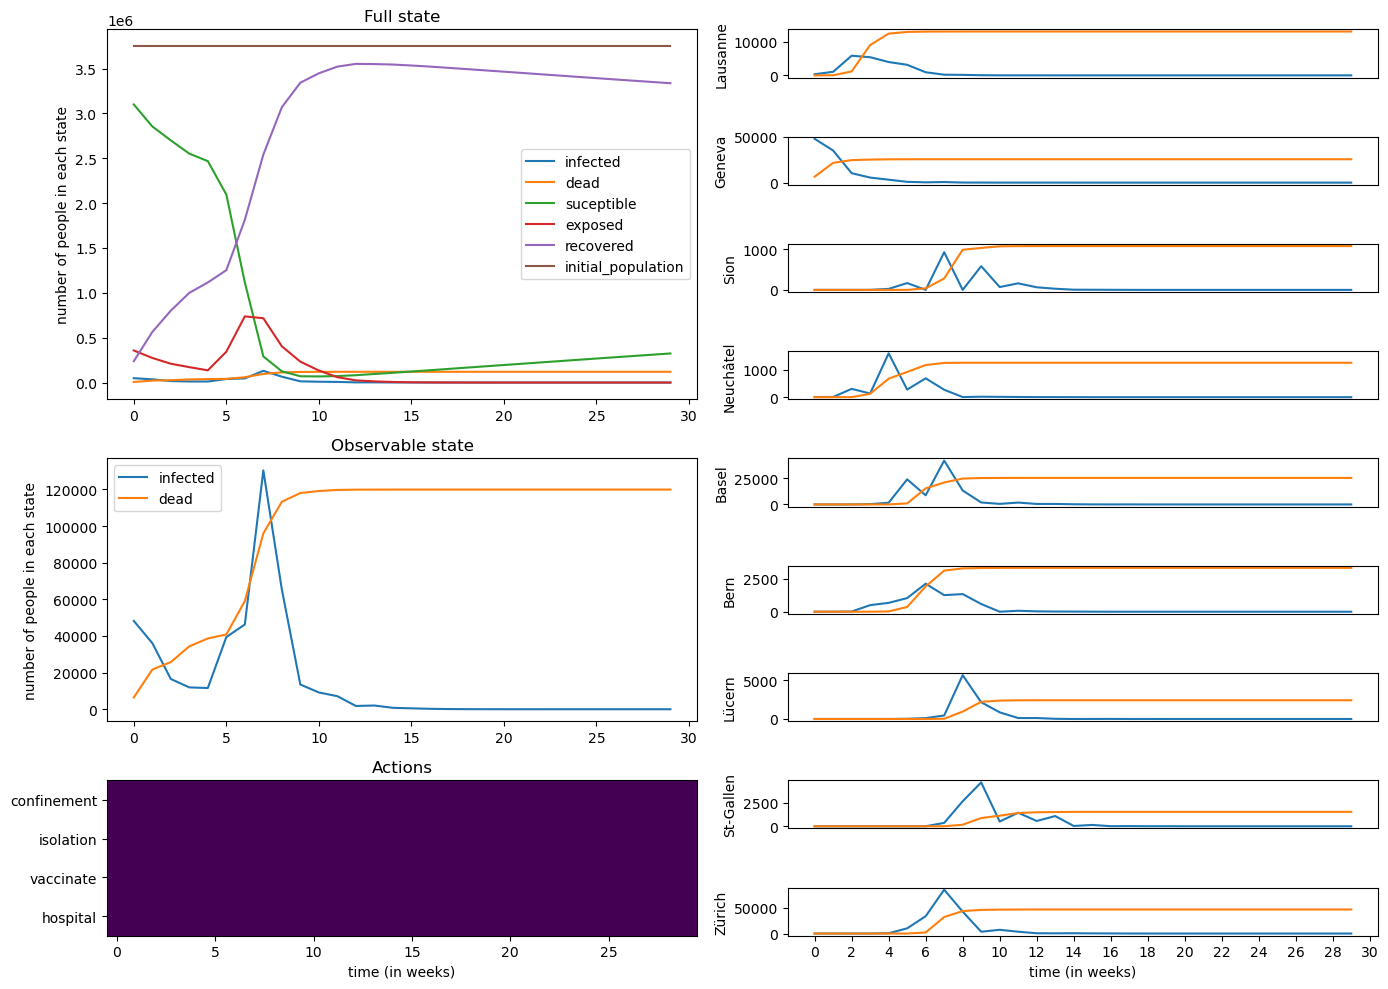

In [6]:
plot_info(total, cities, actions)

### DISCUSSION: TO DOOOOOO

## Question 2: Professor Russo's Policy

### Question 2.a: Implement Pr. Russo's Policy (`RussoAgent`)
We implement Pr. Russo’s Policy as a python class (subclass the Agent abstract class provided with the project files) and initialize the agent accordingly. This choice has been made to make the interaction with the initialized environment easier.

Pr. Russo's Policy consists in confining (`ACTION_CONFINE`) the population for 4 weeks once the amount of infected people exceeds 20000 units. The *confinement action* is not debatable during the confinment. This means that confinments happen in blocks of (at least) 4 weeks each and, potentially, multiples of 4 weeks.

In [7]:
class RussoAgent(Agent): # Agent is the superclass
    def __init__(self,  env:Env):
        """
        Initialization of the agent
        """
        self.env = env
        
        # Initializing variables to keep trace of weeks to wait to end confinement
        self.count_remaining_weeks = 0
        
        # Initializing default and confinement action, which are returned by the act method depending
        # on the amount of infected people
        self.default_action  = { # DO NOTHING
                                'confinement': False, 
                                'isolation': False, 
                                'hospital': False, 
                                'vaccinate': False,
                            }
        self.confinement_action = { # CONFINE
                                    'confinement': True, 
                                    'isolation': False, 
                                    'hospital': False, 
                                    'vaccinate': False,
                                }
        
        # Initializing variables to keep trace of the number of weeks of confinement
        self.confinement_weeks_count = 0
        
    def load_model(self, savepath):
        # This is where one would define the routine for loading a pre-trained model
        # This is not initialized since the model does not need to be trained
        pass

    def save_model(self, savepath):
        # This is where one would define the routine for saving the weights for a trained model
        # This is not initialized since the model does not need to be trained        
        pass

    def optimize_model(self):
        # This is where one would define the optimization step of an RL algorithm
        # This is not initialized since the model does not need to be trained
        return 0
    
    def reset(self, env):
        # This should be called when the environment is reset (we do not loss any weight, no need to 
        # redefine actions, the environment is new and we need to save it)
        self.env = env
        self.count_remaining_weeks = 0
        self.confinement_weeks_count = 0
    
    def act(self, info):
        # This method takes an observation and returns an action
        if self.count_remaining_weeks == 0:
            total_infected = info.total.infected # number of infected people at end of the week
            
            if total_infected > 20000:
                self.count_remaining_weeks = 3 # since we have just taken the action, there are still 3 weeks to wait
                self.confinement_weeks_count += 1
                return self.confinement_action
            
            else:
                return self.default_action
                
        else:
            self.count_remaining_weeks -= 1
            self.confinement_weeks_count += 1
            return self.confinement_action
            
agent = RussoAgent(env)

We now run a simulation applying Pr. Russo's Policy to produce the four plots required.

In [8]:
""" Run the simulation """
log = []
finished = False
obs, info = env.reset(seed) # initialization (random infection)
agent.reset(env) # useless
agent.epsilon = 0 # taken from Agent, which is superclass
while not finished:
    action = agent.act(info)
    obs, R, finished, info = env.step(action)
    log.append(info) # save the information dict for logging
    if finished:
        break

total = {p:np.array([getattr(l.total,p) for l in log]) for p in dyn.parameters}
cities = {c:{p:np.array([getattr(l.city[c],p) for l in log]) for p in dyn.parameters} for c in dyn.cities}
actions = {a:np.array([l.action[a] for l in log]) for a in log[0].action.keys()}

We plot the results. Rather then visualize every single result in different cells, we decide to use the code provided by the teaching team in the tutorial.

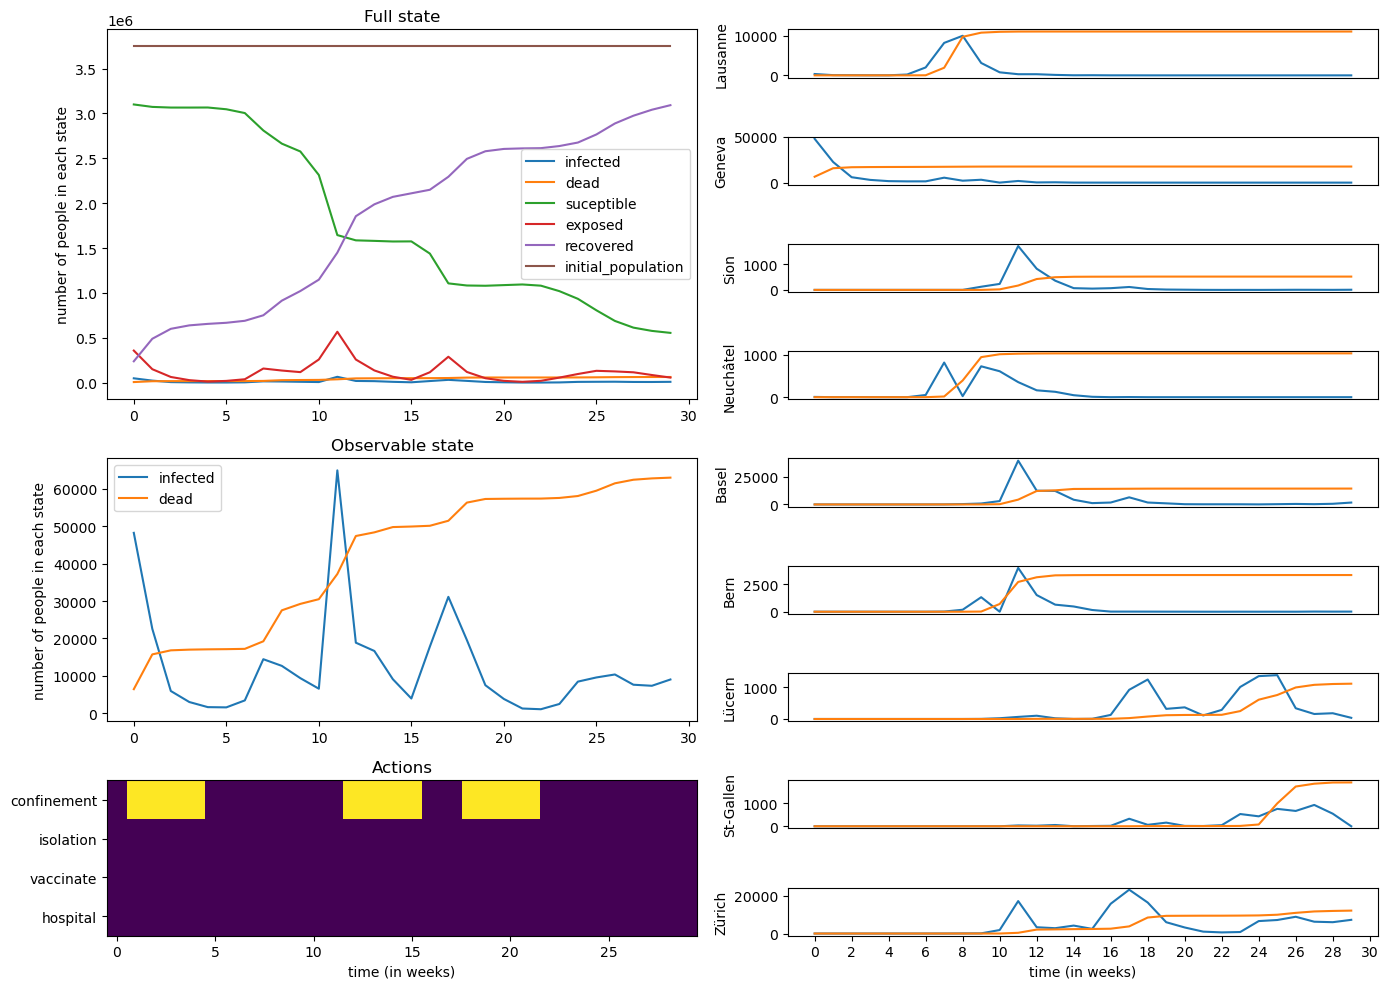

In [9]:
plot_info(total, cities, actions)

### Question 2.b: Evaluate Pr. Russo's Policy

In order to be able to make meaningful conclusions, we implement the following evaluation procedure: we run 50 simulation episodes where actions are chosen from Pr. Russo's Policy.

Notice that, to make results reproducible, we initialize one seed for every episode in the simulation: the i-th simulation corresponds to `seed = i`

In [10]:
# Initializing Russo Agent
agent = RussoAgent(env)
# Initializing the seeds for reproducibility purposes
seeds = range(1,51)

# Initializing useful variables to store results
conf_days = []
rewards = []
deaths = []

# Looping over 50 episodes
for trace in tqdm(range(50)): # for loop over episodes
    # Initializing provisional variable to save cumulative (non discounted) rewards
    R_cumulative = 0
    finished = False
    # Resetting the environment
    obs, info = env.reset(seeds[trace]) 
    # Synchronizing the agent with the newly defined environment
    agent.reset(env)
    
    # Looping over 30 weeks (lenght of one episode as defined in the pdf)
    for t in range(30):
        action = agent.act(info)
        obs, R, finished, info = env.step(action) 
        R_cumulative+= R.item()
        if finished:
            break
            
    """ Parse the logs """
    # Saving total number of confined days
    conf_days.append(7 * agent.confinement_weeks_count)
    # R_cumulative is computed in the inner loop
    rewards.append(R_cumulative)
    # Number of total deaths in the current episode
    deaths.append(info.total.dead)

100%|██████████| 50/50 [00:13<00:00,  3.82it/s]


We plot the histograms of the required quantities, in order to later compare the performance of this model with some more advanced Deep Reinforcement Learning Model. Again, the code for plotting histograms is taken from the miniproject tutorial and it is available in the `helper.py` file.

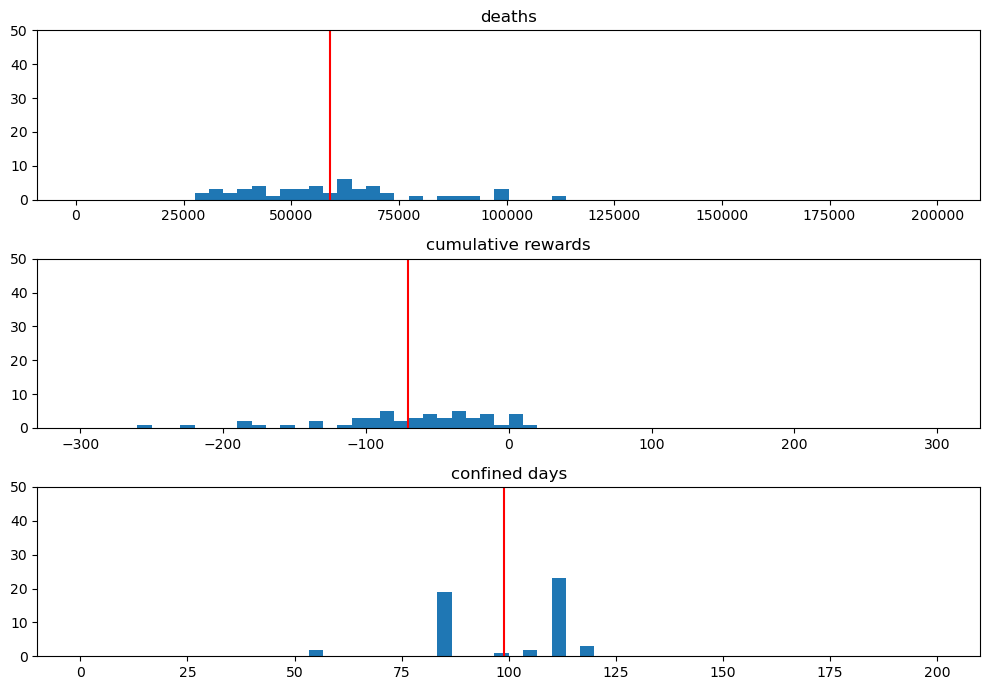

Average death number: 59053.52
Average number of confined days: 98.98
Average cumulative reward: -70.61567765619606


In [11]:
plot_histograms(deaths, rewards, conf_days)

## Prerequisites and needed data structures for the following tasks (Question 3, 4 and 5)

In the following tasks, we are going to work with Deep Reinforcement Learning Models. In particular, despite some small variations regarding the action and observatin spaces, we are going to implement a DQN model.
It is therefore necessary to implement a memory buffer (to store transitions to be used during the off-policy update) and the general structure of the network we are going to use. Notice that all the technical choices, including the choice of hyperparameters, are taken following the suggestions provided by the teaching staff.

#### Initializing useful parameters

In [12]:
# BATCH_SIZE is the number of transitions sampled from the replay buffer
BATCH_SIZE = 2048
# GAMMA is the discount factor
GAMMA = 0.9
# EPS_START is the starting value of epsilon
EPS_START = 0.7
# EPS_END is the final value of epsilon (in case of decaying epsilon,meant to reduce the exploration)
EPS_MIN = 0.2
# DECREASE_FLAG indicates whether we want to decrease the exploration
DECREASE_FLAG = False
# EXPLORATION_FLAG indicates whether we want to explore or not
EXPLORATION_FLAG = True
# LR is the learning rate of the AdamW optimizer
LR = 5e-3
# Update rate of the target network
TAU = 1
# Criterion to use in order to compute the loss (Huber Loss)
criterion = torch.nn.SmoothL1Loss()  

#### Memory Buffer (`ReplayMemory`)

In order to save the transitions obtained from the interactions with the environment, we need to implement a Memory Buffer using a queue. To better deal with the data later, it is useful to assign a precise schema to each element of the buffer. This is achieved by defining the tuple scheme `Transition`

In [13]:
# The following is a named tuple representing a single transition in our environment
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

# The following is a cyclic buffer of bounded size that holds the transitions observed recently. 
# It also implements a .sample() method for selecting a random batch of transitions for training.
class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

#### Deep Q-Learning Network (`DQN`)

We define the network architecture we are going to use in the following tasks. The structure (layers) and the hyperparameters are chosen accordingly to the table provided in the pdf.

In [14]:
class DQN(torch.nn.Module):

    def __init__(self, n_observations, n_actions):
        super().__init__()
        
        # MLP network
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(n_observations, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 16),
            torch.nn.ReLU(),  
            torch.nn.Linear(16, n_actions)
        )
        
    # Called in order to compute the forward pass in the network
    def forward(self, x):
        # We flatten the input in order to use it in the linear network
        # Since we might end up having very small input values due to the scaling (see observation_preprocessor),
        # we compute **(1/4) to increase the magnitude of each term (which is non negative by the dynamics of
        # the problem)
        new_x = torch.flatten(x,1) ** (1/4) 
        return self.mlp(new_x)

#### Defining a new Agent: `DQNAgent`

In order to interact with the environment, we define `DQNAgent` class. 

In [15]:
class DQNAgent(Agent): #superclass
    def __init__(self, env: Env, Net_Constructor, n_observations, n_actions):
        """DQN Agent implementation"""
        
        # MLP networks. Policy net and target net are used in order to compute the Qvalues
        self.policy_net = Net_Constructor(n_observations, n_actions).to(device)
        self.target_net = Net_Constructor(n_observations, n_actions).to(device)
        # We initialize the target network using the parameters of the policy network
        self.target_net.load_state_dict(self.policy_net.state_dict())
        # We initialize the optimizer using the suggeseted learning rate (it must act on policy_net parameters)
        self.optimizer = torch.optim.AdamW(self.policy_net.parameters(), lr=LR, amsgrad=True) # we initialize the optimizer
        
        self.env = env

    def load_model(self, PATH):
        """Routine for loading a pre-trained model"""
        self.policy_net.load_state_dict(PATH)
        pass

    def save_model(self, PATH):
        """Routine for saving the weights for a trained model"""
        torch.save(self.policy_net.state_dict(), PATH + '.pt')

    def optimize_model(self, memory, criterion):
        """Routine to perform the optimization step to update policy net parameters"""
        
        # If there aren't enough data in the memory buffer, avoid computing update step
        if len(memory) < BATCH_SIZE:
            return
        
        # Sampling the transitions from the memory buffer
        transitions = memory.sample(BATCH_SIZE)
        # Transpose the batch. This converts batch-array of Transitions to Transition of batch-arrays.
        batch = Transition(*zip(*transitions))

        # Compute a mask of non-final states and concatenate the batch elements, moving the final results to the device
        # (a final state would've been the one after which simulation ended)
        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
        
        # We save the non final state in our sampling
        non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
        
        # We save and concatenate the variables we need
        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)
        
        # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
        # columns of actions taken. These are the actions which would've been taken
        # for each batch state according to policy_net
        state_action_values = self.policy_net(state_batch)
        state_action_values = state_action_values.gather(1, action_batch)
        
        # Compute V(s_{t+1}) for all next states.
        # Expected values of actions for non_final_next_states are computed based
        # on the "older" target_net; selecting their best reward with max(1)[0].
        # This is merged based on the mask, such that we'll have either the expected
        # state value or 0 in case the state was final.
        next_state_values = torch.zeros(BATCH_SIZE, device=device)
        with torch.no_grad():
            # we compute max_a Q(s', a) in order to quantify the delta. We use the target net to improve stability
            next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1)[0]
            
        # Compute the expected Q values
        expected_state_action_values = (next_state_values * GAMMA) + reward_batch

        # Compute Huber loss
        loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))
        
        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        # In-place gradient clipping
        torch.nn.utils.clip_grad_value_(self.policy_net.parameters(), 100)
        self.optimizer.step()
    
    def reset(self,):
        # This should be called when the environment is reset
        pass
        
    def act(self, state, decrease_flag, exploration_flag, curr_episode):
        """ The following function defines the policy deployed in order to explore and interact with the environments.
            In particular, it is an epsilon greedy policy (if exploration_flag == True) based on the values provided by 
            the network trained up to this moment. The method takes an observation and returns an action. """
        
        # In case of random action, the action can be directly sampled using self.env.action_space.sample()
        sample = random.random()

        # In case of decreasing exploration rate, the total number of episodes is needed
        num_episodes = 500
        
        # Setting the epsilon parameter to have or avoid exploration
        if exploration_flag:
            if decrease_flag:
                eps_threshold = max(EPS_START*(num_episodes-curr_episode)/num_episodes, EPS_MIN)
            else:
                eps_threshold = EPS_START
        else:
            eps_threshold = 0 # in this case we only consider the greedy policy determined by the network
            
        if sample >= eps_threshold:
            with torch.no_grad():
                # We use torch.no_grad() since we are now using the network to simply take an action.
                # We do not need to expand the DAG and consider this computation in the backprop step.
                # We only consider the larger value to take the action.
                return self.policy_net(state).max(1)[1].view(1,1) # this format is needed to concatenate
        else:
            return torch.tensor([[self.env.action_space.sample()]], device=device, dtype=torch.long)

## Question 3: Deep Q-Learning with a binary action space

### Question 3.a: Implementing Deep Q-Learning

Since the action space is binary and the observation space contains the measurement of the proportion of dead and infected people in each city, each day of a given week, we define `action_preprocessor` and `observation_preprocessor` to convert data from environment and neural network (and viceversa).

`action_preprocessor`: the deafult action (Do Nothing) is encoded as 0, the CONFINEMENT action is encoded as 1.

We define it to convert the actions returned by the network (`torch.Tensor`) to actions recognized by the environment (`Python dictionaries`)

In [16]:
ACTION_NULL = 0
ACTION_CONFINE = 1

def action_preprocessor(a:torch.Tensor, dyn:ModelDynamics):
    action = { # DO NOTHING
        'confinement': False, 
        'isolation': False, 
        'hospital': False, 
        'vaccinate': False}
    
    # If a == 1 (the network returns 1), then do confinement
    if a == ACTION_CONFINE:
        action['confinement'] = True
        
    return action

`observation_preprocessor`: every observation (`Python dictionaries`) is converted to a `torch.Tensor` containing the proportion of dead and infected people in each city.

Since the observation space contains the measurement of the proportion of dead and infected people in each city
we naively scale the observation space with `SCALE = 1`.

In [17]:
SCALE = 1
def observation_preprocessor(obs: Observation, dyn:ModelDynamics):
    infected = SCALE * np.array([np.array(obs.city[c].infected)/obs.pop[c] for c in dyn.cities])
    dead = SCALE * np.array([np.array(obs.city[c].dead)/obs.pop[c] for c in dyn.cities])
    return torch.Tensor(np.stack((infected, dead))).unsqueeze(0)

We now initialize the environment making sure to define the appropriate observation and action spaces. This is essential, since the action and observation format needed by the dynamic model is different from the encoding taken as input by the neural network we are going to train. As we have already seen, this is exactly what makes preprocessors necessary.

In [18]:
# Initializing the environment
env = Env(  dyn, # We pass the dynamical model to the environment 
            action_space=spaces.Discrete(2) , # Here one could pass an openai gym action space that can then be sampled
            observation_space=spaces.Box(low=0, high=1, shape=(2,9,7)),
            action_preprocessor=action_preprocessor,
            observation_preprocessor=observation_preprocessor)

We now initiliaze the models and other additional useful variables that will be used in the training and evaluation procedure.

In [19]:
# Training and evaluation parameters
num_episodes = 500
num_eval_episodes = 20
num_weeks = 30

# Evaluation seeds (for reproducibility purposes)
eval_seeds = np.arange(1, 21)

# Training seeds (for reproducibility purposes)
training_seeds = np.random.randint(22, 10000, size=1500)

# Initializing empty lists to save results
training = []
evaluation = []

# Initialize the directory to save the model and results of task 3.a
makedirs('./checkpoints_task3a', exist_ok=True)
rmtree('./checkpoints_task3a')
makedirs('./checkpoints_task3a')
PATH = './checkpoints_task3a/policy_net'

# We run the training and evaluation procedures 3 times, thus obtaining 3 different models. To analyse the
# performance of such approach, we are going to consider the best model among the obtained ones

for training_process in range(3):
    
    print('\n TRAINING PROCESS :{} \n'.format(training_process+1))

    # Ensuring reproducibility, making the net initialization deterministic
    torch.manual_seed(training_process)
    torch.use_deterministic_algorithms(True)
    
    # Initialize the agent for the current training_process
    agent = DQNAgent(env, Net_Constructor=DQN, n_observations=2*9*7, n_actions=2)
    
    # We initialize the buffer from which we sample already observed transitions
    memory = ReplayMemory(20000) 
    
    # Initialize list to keep trace of log rewards
    training_trace = []
    eval_trace = []
    
    # Looping through the episodes (500 per training process)
    for i_episode in tqdm(range(num_episodes)):
        
        # if (i_episode % 10) == 0:
        #     print('Training episode :{}'.format(i_episode))

        # Initialize variable to keep trace of the total reward
        total_training_reward = 0
        
        # Initialize the environment and get its state (moving it to the device)
        state, info = env.reset(training_seeds[500*training_process + i_episode])
        state = torch.tensor(state, device=device)

        # We run an episode
        for t in range(num_weeks):
            
            # For task 3a: DECREASE_FLAG=False and EXPLORATION_FLAG=True
            action = agent.act(state, DECREASE_FLAG, EXPLORATION_FLAG, i_episode)
            obs, reward, done, info = env.step(action.item())

            total_training_reward += reward.item()
            reward = torch.tensor([reward], device=device)

            if done: # in our case it corresponds to 30 weeks
                next_state = None
            else:
                next_state = torch.tensor(obs, device=device)

            # Store the transition in memory (in the replay buffer)
            memory.push(state, action, next_state, reward)

            # We run a training step on policy_net
            agent.optimize_model(memory, criterion)

            # Move to the next state
            state = next_state

            if done:
                break

        # We log the cumulative reward to training trace
        training_trace.append(total_training_reward)

        if ((i_episode + 1) % 5 == 0):

            # We update the target network every 5 epsiodes (using a convex linear combination of the parameters)
            policy_net_state_dict = agent.policy_net.state_dict()
            target_net_state_dict = agent.target_net.state_dict()
            for key in policy_net_state_dict:
                target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)

            # Changing the parameters of the target network
            agent.target_net.load_state_dict(target_net_state_dict)
            
        # If the following condition is satisfied, we compute an evaluation procedure
        if ((i_episode + 1) % 50 == 0) or ((i_episode + 1) == 500):

            # print('Evaluation cycle: {}'.format(int((i_episode + 1) / 50)))
            average_rewards = []

            for new_episode in range(num_eval_episodes):

                total_eval_reward = 0
                state, info = env.reset(eval_seeds[new_episode])
                state = torch.tensor(state, device=device)

                for new_week in range(num_weeks):
                    
                    # Notice that, once evaluating the model, EXPLORATION_FLAG=False (greedy policy)
                    action = agent.act(state, DECREASE_FLAG, False, new_episode)
                    obs, reward, done, info = env.step(action.item())
                    total_eval_reward += reward.item()

                    if done: # in our case it corresponds to 30 weeks
                        next_state = None
                    else:
                        next_state = torch.tensor(obs, device=device)

                    # Move to the next state
                    state = next_state

                    if done:
                        break

                average_rewards.append(total_eval_reward)

            eval_trace.append(np.mean(average_rewards))
    
    agent.save_model(PATH + str(training_process))        
    training.append(training_trace)
    evaluation.append(eval_trace)

print('Complete')


 TRAINING PROCESS :1 



 52%|█████▏    | 260/500 [36:37<10:44:38, 161.16s/it]

We plot the results obtained during the training and evaluation procedures. Every figure corresponds to a different training procedure. Once again, plot code is available in `helper.py` file.

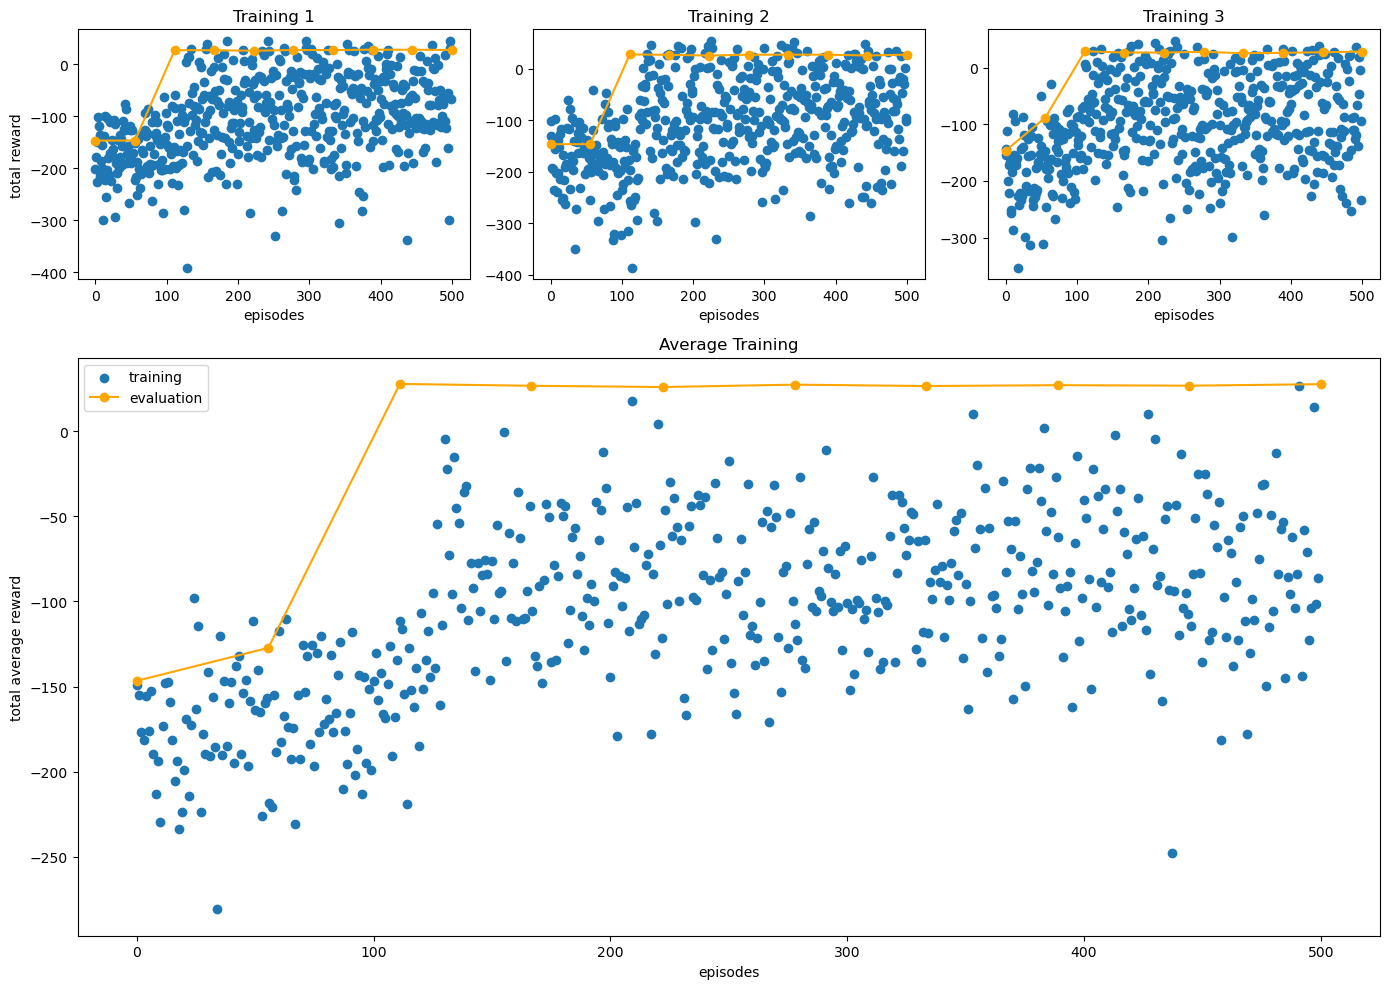

In [29]:
plot_training_eval(training, evaluation)

We now proceed to load the best model among the 3. The choice is made depending on the last evaluation value that has been recorded for each process.

In [30]:
# We select the best model after comparing the last evaluation entries for each training process
final_performance = np.array([evaluation[0][-1], evaluation[1][-1], evaluation[2][-1]])
best_model_idx = np.argmax(final_performance)

# We initialize a new network with the parameters of the best network
best_file = torch.load(PATH + str(best_model_idx) + '.pt')
best_agent_const = DQNAgent(env, DQN,n_observations=2*9*7, n_actions=2)
best_agent_const.policy_net.load_state_dict(best_file)

# We create a directory to save the model. This is useful in order not to run the whole training procedure again
makedirs('./checkpoints_final', exist_ok=True)
rmtree('./checkpoints_final')
makedirs('./checkpoints_final')
PATH = './checkpoints_final/task3a'

# Saving the model parameters
torch.save(best_agent_const.policy_net.state_dict(), PATH + '.pt')

Then, we proceed simulating 3 episodes using the policy induced by the network. Subsequently, we plot the results of one of these episodes to evaluate and discuss the effects of the policy.

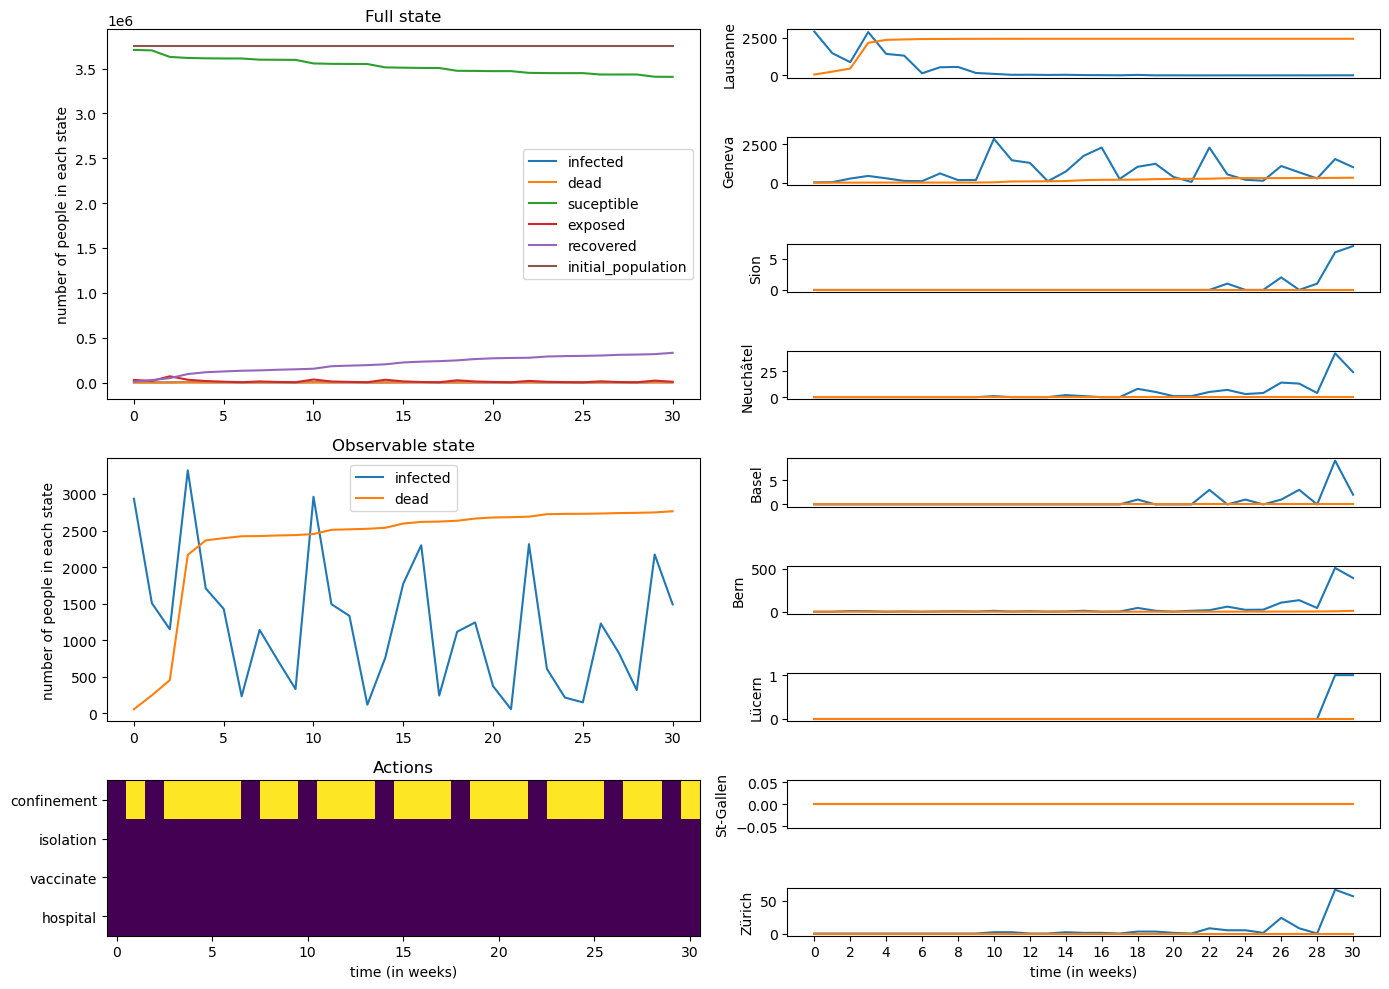

In [34]:
""" Run three simulation """
seeds = np.arange(42, 45)

log = []
    
agent = best_agent_const

for i_episode in range(3):

    episode_log = []
    
    # Initialize the environment and get its state (moving it to the device)
    state, info = env.reset(seeds[i_episode])
    episode_log.append(info)
    state = torch.tensor(state, device=device)

    # We run an episode
    for t in range(num_weeks):

        action = agent.act(state, DECREASE_FLAG, False, i_episode)
        obs, reward, done, info = env.step(action.item())
        episode_log.append(info)

        if done: # in our case it corresponds to 30 weeks
            next_state = None
        else:
            next_state = torch.tensor(obs, device=device)

        # Move to the next state
        state = next_state

        if done:
            break

    log.append(episode_log)

# computing useful quantities to then plot and visualize the effects of the network
total_secondepisode = {p:np.array([getattr(l.total,p) for l in log[1]]) for p in dyn.parameters}
cities_secondepisode = {c:{p:np.array([getattr(l.city[c],p) for l in log[1]]) for p in dyn.parameters} for c in dyn.cities}
actions_secondepisode = {a:np.array([l.action[a] for l in log[1]]) for a in log[1][0].action.keys()}

plot_info(total_secondepisode, cities_secondepisode, actions_secondepisode)

## DISCUSSIONE DA FAREEEE

### Question 3.b: Decreasing exploration

In [35]:
# DECREASE_FLAG indicates whether we want to decrease the exploration
DECREASE_FLAG = True

Now we can implement a different exploration policy by adjusting some parameters. 

In particular, we want to implement a decrease in the exploration threshold.
This is done to advantage exploration over exploitation in the first stage of the training process, in order to speed up the learning process. On the other hand, the deeper we go in the training, the more information we have about the environment and the transitions, therefore we decrease the exploration coefficient in order to take advantage of exploitation. 

In [36]:
# Training and evaluation parameters
num_episodes = 500
num_eval_episodes = 20
num_weeks = 30

# Evaluation seeds (for reproducibility purposes)
eval_seeds = np.arange(1, 21)

# Training seeds (for reproducibility purposes)
training_seeds = np.random.randint(22, 10000, size=1500)

# Initializing empty lists to save results
training = []
evaluation = []

# Initialize the directory to save the model and results of task 3.b
makedirs('./checkpoints_task3b', exist_ok=True)
rmtree('./checkpoints_task3b')
makedirs('./checkpoints_task3b')
PATH = './checkpoints_task3b/policy_net'

# We run the training and evaluation procedures 3 times, thus obtaining 3 different models. To analyse the
# performance of such approach, we are going to consider the best model among the obtained ones
for training_process in range(3):
    
    print('\n TRAINING PROCESS :{} \n'.format(training_process+1))
    
    torch.manual_seed(training_process)
    torch.use_deterministic_algorithms(True)
    
    agent = DQNAgent(env, Net_Constructor=DQN, n_observations=2*9*7, n_actions=2)
    memory = ReplayMemory(20000) # we initialize the buffer from which we sample already observed transitions
    
    # Initialize list to keep trace of log rewards
    training_trace = []
    eval_trace = []
    
    # Looping through the episodes (500 per training process)
    for i_episode in tqdm(range(num_episodes)):
        
        # if (i_episode % 10) == 0:
        #     print('Training episode :{}'.format(i_episode))

        # Initialize variable to keep trace of the total reward
        total_training_reward = 0
        # Initialize the environment and get its state (moving it to the device)
        state, info = env.reset(training_seeds[500*training_process + i_episode])
        state = torch.tensor(state, device=device)

        # We run an episode
        for t in range(num_weeks):
            
            # For task 3b: DECREASE_FLAG=True and EXPLORATION_FLAG=True
            action = agent.act(state, DECREASE_FLAG, EXPLORATION_FLAG, i_episode)
            obs, reward, done, info = env.step(action.item())

            total_training_reward += reward.item()
            reward = torch.tensor([reward], device=device)

            if done: # in our case it corresponds to 30 weeks
                next_state = None
            else:
                next_state = torch.tensor(obs, device=device)

            # Store the transition in memory (in the replay buffer)
            memory.push(state, action, next_state, reward)

            # Move to the next state
            state = next_state

            if done:
                break

        # We log the cumulative reward to training trace
        training_trace.append(total_training_reward)

        # We run a training step on policy_net
        agent.optimize_model(memory, criterion)

        if ((i_episode + 1) % 5 == 0):

            # We update the target network every 5 epsiodes
            policy_net_state_dict = agent.policy_net.state_dict()
            agent.target_net.load_state_dict(policy_net_state_dict)

        if ((i_episode + 1) % 50 == 0) or ((i_episode + 1) == 500):

            # print('Evaluation cycle: {}'.format(int((i_episode + 1) / 50)))
            average_rewards = []

            for new_episode in range(num_eval_episodes):

                total_eval_reward = 0
                state, info = env.reset(eval_seeds[new_episode])
                state = torch.tensor(state, device=device)

                for new_week in range(num_weeks):
                    
                    # Notice that, once evaluating the model, EXPLORATION_FLAG=False (greedy policy)
                    action = agent.act(state, DECREASE_FLAG, False, new_episode) # greedy policy when eploration_flag = False
                    obs, reward, done, info = env.step(action.item())
                    total_eval_reward += reward.item()

                    if done: # in our case it corresponds to 30 weeks
                        next_state = None
                    else:
                        next_state = torch.tensor(obs, device=device)

                    # Move to the next state
                    state = next_state

                    if done:
                        break

                average_rewards.append(total_eval_reward)

            eval_trace.append(np.mean(average_rewards))
    
    agent.save_model(PATH + str(training_process))        
    training.append(training_trace)
    evaluation.append(eval_trace)

print('Complete')


 TRAINING PROCESS :1 

Training episode :0
Training episode :10
Training episode :20
Training episode :30
Training episode :40
Evaluation cycle: 1
Training episode :50
Training episode :60
Training episode :70
Training episode :80
Training episode :90
Evaluation cycle: 2
Training episode :100
Training episode :110
Training episode :120
Training episode :130
Training episode :140
Evaluation cycle: 3
Training episode :150
Training episode :160
Training episode :170
Training episode :180
Training episode :190
Evaluation cycle: 4
Training episode :200
Training episode :210
Training episode :220
Training episode :230
Training episode :240
Evaluation cycle: 5
Training episode :250
Training episode :260
Training episode :270
Training episode :280
Training episode :290
Evaluation cycle: 6
Training episode :300
Training episode :310
Training episode :320
Training episode :330
Training episode :340
Evaluation cycle: 7
Training episode :350
Training episode :360
Training episode :370
Training ep

We plot the obtained results to discuss the effects of the policy.

In [ ]:
plot_training_eval(training, evaluation)

We now proceed to load the best model among the 3. The choice is made depending on the last evaluation value that has been recorded for each process.

In [ ]:
# We select the best model after comparing the last evaluation entries for each training process
final_performance = np.array([evaluation[0][-1], evaluation[1][-1], evaluation[2][-1]])
best_model_idx = np.argmax(final_performance)

# We initialize a new network with the parameters of the best network
best_file = torch.load(PATH + str(best_model_idx) + '.pt')
best_agent_decreasing = DQNAgent(env, DQN, n_observations=2*9*7, n_actions=2)
best_agent_decreasing.policy_net.load_state_dict(best_file)

# We save the model. This is useful in order not to run the whole training procedure again
PATH = './checkpoints_final/task3b'
torch.save(best_agent_decreasing.policy_net.state_dict(), PATH + '.pt')

We now proceed to simulate 3 episodes using the policy induced by the network. We then plpot the results of one of these episodes to evaluate and discuss the effects of the policy.

In [ ]:
""" Run three simulation """
seeds = np.arange(42, 45)

log = []
    
agent = best_agent_decreasing

for i_episode in range(3):

    episode_log = []
    
    # Initialize the environment and get its state (moving it to the device)
    state, info = env.reset(seeds[i_episode])
    episode_log.append(info)
    state = torch.tensor(state, device=device)

    # We run an episode
    for t in range(num_weeks):

        action = agent.act(state, DECREASE_FLAG, False, i_episode)
        obs, reward, done, info = env.step(action.item())
        episode_log.append(info)

        if done: # in our case it corresponds to 30 weeks
            next_state = None
        else:
            next_state = torch.tensor(obs, device=device)

        # Move to the next state
        state = next_state

        if done:
            break

    log.append(episode_log)

total_secondepisode = {p:np.array([getattr(l.total,p) for l in log[1]]) for p in dyn.parameters}
cities_secondepisode = {c:{p:np.array([getattr(l.city[c],p) for l in log[1]]) for p in dyn.parameters} for c in dyn.cities}
actions_secondepisode = {a:np.array([l.action[a] for l in log[1]]) for a in log[1][0].action.keys()}

plot_info(total_secondepisode, cities_secondepisode, actions_secondepisode)

### Question 3.c: Evaluate the best performing policy against Pr. Russo’s policy

## TO DOOOOOOO

## Question 4: Dealing with a more complex action Space

## Question 4.1

Setting the parameters

In [ ]:
# Learning Rate
LR = 10e-5

### Question 4.a

con 5 neuroni in più nell'input (embedding dell'azione alla settimana prima) ci fa risparmiare 2^5 neuroni in uscita
in uscita abbiamo quindi 5 neuroni invece che 2^5

nel caso tabular con (stato agnostico alla situazione attuale sulle azioni), in output dovremmo quindi avere 2^5 neuroni, il che vorrebbe dire che potenzialmente potremmo prendere più 'toggle' contemporaneamente, che non è possibile

dando informazioni sull'azione in input, invece, possiamo ridurre l'output a 5 neuroni e poi applicare una softmax per scegliere quale toggle applicare
In questo modo imponiamo che possa essere switchata solo una azione alla volta

In [ ]:
# Action Preprocessor: the deafult action (Do Nothing) is encoded as 0, the CONFINEMENT action is encoded as 1

TOGGLE_NULL = 0
TOGGLE_CONFINEMENT = 1
TOGGLE_ISOLATION = 2
TOGGLE_HOSPITAL = 3
TOGGLE_VACCINATION = 4

def action_preprocessor(a:torch.Tensor, dyn:ModelDynamics):
    
    default_action = { # DO NOTHING
        'confinement': False, 
        'isolation': False, 
        'hospital': False, 
        'vaccinate': False}
    
    if a not in range(0, 5):
        print('Not a valid action!')
        return default_action
    
    
    action = dyn.get_action()
    
    if a == TOGGLE_NULL: 
        return action
    elif a == TOGGLE_CONFINEMENT:
        action['confinement'] = not action['confinement'] 
    elif a == TOGGLE_ISOLATION:
        action['isolation'] = not action['isolation']
    elif a == TOGGLE_HOSPITAL:
        action['hospital'] = not action['hospital']
    else: 
        action['vaccinate'] = not action['vaccinate']
    
    return action

# Observation Preprocessor: every observation is converted to a tensor containing the proportion of death and
# infected people in each city

SCALE = 1
def observation_preprocessor(obs: Observation, dyn:ModelDynamics):
    infected = SCALE * np.array([np.array(obs.city[c].infected)/obs.pop[c] for c in dyn.cities])
    dead = SCALE * np.array([np.array(obs.city[c].dead)/obs.pop[c] for c in dyn.cities])
    
    curr_action = torch.Tensor(4)
    curr_action[0] = 1 if dyn.get_action()['confinement'] else 0
    curr_action[1] = 1 if dyn.get_action()['isolation'] else 0
    curr_action[2] = 1 if dyn.get_action()['hospital'] else 0
    curr_action[3] = 1 if dyn.get_action()['vaccinate'] else 0
    
    ret = torch.flatten(torch.Tensor(np.stack((infected, dead))).unsqueeze(0),1)
    ret = torch.cat([ret, curr_action.unsqueeze(dim=0)], dim=1)
    
    return ret

In [ ]:
# Initializing the environment
env = Env(  dyn, # We pass the dynamical model to the environment 
            action_space=spaces.Discrete(5) , # Here one could pass an openai gym action space that can then be sampled
            # observation_space=spaces.Box(low=0, high=1, shape=(2,9,7)),
            action_preprocessor=action_preprocessor,
            observation_preprocessor=observation_preprocessor)

In [ ]:
num_episodes = 500
num_eval_episodes = 20
num_weeks = 30

# training seeds
training_seeds = np.random.randint(22, 10000, size=1500)

# evaluation seeds
eval_seeds = np.arange(1, 21)

training = []
training_weights = []
evaluation = []

makedirs('./checkpoints_task4a', exist_ok=True)
rmtree('./checkpoints_task4a')
makedirs('./checkpoints_task4a')
PATH = './checkpoints_task4a/policy_net'

for training_process in range(3):
    
    print('\n TRAINING PROCESS :{} \n'.format(training_process+1))
    
    torch.manual_seed(training_process)
    torch.use_deterministic_algorithms(True)
    
    agent = DQNAgent(env, Net_Constructor=DQN, n_observations=2*9*7, n_actions=2)
    memory = ReplayMemory(20000) # we initialize the buffer from which we sample already observed transitions
    
    # Initialize list to keep trace of log rewards
    training_trace = []
    eval_trace = []

    for i_episode in tqdm(range(num_episodes)):
        
        # if (i_episode % 10) == 0:
        #     print('Training episode :{}'.format(i_episode))

        # Initialize variable to keep trace of the total reward
        total_training_reward = 0
        # Initialize the environment and get its state (moving it to the device)
        state, info = env.reset(training_seeds[500*training_process + i_episode])
        state = torch.tensor(state, device=device)

        # We run an episode
        for t in range(num_weeks):

            action = agent.act(state, DECREASE_FLAG, EXPLORATION_FLAG, i_episode)
            obs, reward, done, info = env.step(action.item())

            total_training_reward += reward.item()
            reward = torch.tensor([reward], device=device)

            if done: # in our case it corresponds to 30 weeks
                next_state = None
            else:
                next_state = torch.tensor(obs, device=device)

            # Store the transition in memory (in the replay buffer)
            memory.push(state, action, next_state, reward)

            # Move to the next state
            state = next_state
            
            # We run a training step on policy_net
            agent.optimize_model(memory, criterion)

            if done:
                break

        # We log the cumulative reward to training trace
        training_trace.append(total_training_reward)

        if ((i_episode + 1) % 5 == 0):

            # We update the target network every 5 epsiodes
            policy_net_state_dict = agent.policy_net.state_dict()
            agent.target_net.load_state_dict(policy_net_state_dict)

        if ((i_episode + 1) % 50 == 0) or ((i_episode + 1) == 500):

            # print('Evaluation cycle: {}'.format(int((i_episode + 1) / 50)))
            average_rewards = []

            for new_episode in range(num_eval_episodes):

                total_eval_reward = 0
                state, info = env.reset(eval_seeds[new_episode])
                state = torch.tensor(state, device=device)

                for new_week in range(num_weeks):

                    action = agent.act(state, DECREASE_FLAG, False, new_episode) # greedy policy when eploration_flag = False
                    obs, reward, done, info = env.step(action.item())
                    total_eval_reward += reward.item()

                    if done: # in our case it corresponds to 30 weeks
                        next_state = None
                    else:
                        next_state = torch.tensor(obs, device=device)

                    # Move to the next state
                    state = next_state

                    if done:
                        break

                average_rewards.append(total_eval_reward)

            eval_trace.append(np.mean(average_rewards))
    
    agent.save_model(PATH + str(training_process))        
    training.append(training_trace)
    training_weights.append(policy_net_state_dict)
    evaluation.append(eval_trace)

print('Complete')

In [ ]:
plot_training_eval(training, evaluation)

In [ ]:
final_performance = np.array([evaluation[0][-1], evaluation[1][-1], evaluation[2][-1]])
best_model_idx = np.argmax(final_performance)

best_file = torch.load(PATH + str(best_model_idx) + '.pt')
best_agent_decreasing = DQNAgent(env, DQN,n_observations=2*9*7, n_actions=2)
best_agent_decreasing.policy_net.load_state_dict(best_file)

PATH = './checkpoints_final/task4a'

torch.save(best_agent_decreasing.policy_net.state_dict(), PATH + '.pt')

In [ ]:
""" Run three simulation """
seeds = np.arange(42, 45)

log = []
    
agent = best_agent_decreasing

for i_episode in range(3):

    episode_log = []
    
    # Initialize the environment and get its state (moving it to the device)
    state, info = env.reset(seeds[i_episode])
    episode_log.append(info)
    state = torch.tensor(state, device=device)

    # We run an episode
    for t in range(num_weeks):

        action = agent.act(state, DECREASE_FLAG, False, i_episode)
        obs, reward, done, info = env.step(action.item())
        episode_log.append(info)

        if done: # in our case it corresponds to 30 weeks
            next_state = None
        else:
            next_state = torch.tensor(obs, device=device)

        # Move to the next state
        state = next_state

        if done:
            break

    log.append(episode_log)

total_secondepisode = {p:np.array([getattr(l.total,p) for l in log[1]]) for p in dyn.parameters}
cities_secondepisode = {c:{p:np.array([getattr(l.city[c],p) for l in log[1]]) for p in dyn.parameters} for c in dyn.cities}
actions_secondepisode = {a:np.array([l.action[a] for l in log[1]]) for a in log[1][0].action.keys()}

plot_info(total_secondepisode, cities_secondepisode, actions_secondepisode)

#### Question 4.1.d

la distanza (in termini di metrica) fra un'azione e la successiva deve essere al più 1
ossia possiamo fare il toggling solo di una azione alla volta (al massimo... volendo si può anche non cambiare nulla)

In [ ]:
def action_preprocessor(a:torch.Tensor, dyn:ModelDynamics):
    action = { # DO NOTHING
        'confinement': False, 
        'isolation': False, 
        'hospital': False, 
        'vaccinate': False}
    
    action['confinement'] = bool(a[0][0])
    action['isolation'] = bool(a[0][1])
    action['hospital'] = bool(a[0][2])
    action['vaccinate'] = bool(a[0][3])
    
    return action

# Observation Preprocessor: every observation is converted to a tensor containing the proportion of death and
# infected people in each city

SCALE = 1
def observation_preprocessor(obs: Observation, dyn:ModelDynamics):
    infected = SCALE * np.array([np.array(obs.city[c].infected)/obs.pop[c] for c in dyn.cities])
    dead = SCALE * np.array([np.array(obs.city[c].dead)/obs.pop[c] for c in dyn.cities])
    return torch.Tensor(np.stack((infected, dead))).unsqueeze(0)

In [ ]:
# Initializing the environment
env = Env(  dyn, # We pass the dynamical model to the environment 
            action_space=spaces.MultiBinary([1, 4]) , # Here one could pass an openai gym action space that can then be sampled
            observation_space=spaces.Box(low=0, high=1, shape=(2,9,7)),
            action_preprocessor=action_preprocessor,
            observation_preprocessor=observation_preprocessor)

In [ ]:
class DQN(torch.nn.Module):

    def __init__(self, n_observations, n_actions):
        super().__init__()
        
        # MLP network
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(n_observations, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 16),
            torch.nn.ReLU(),  
            torch.nn.Linear(16, n_actions)
        )
        
    # Called in order to compute the forward pass in the network
    def forward(self, x):
        new_x = torch.flatten(x,1) ** (1/4) # since we might end up having very small input values due to the scaling
                                            # We flatten the input in order to use it in the linear network
        z = self.mlp(new_x)
        
        return torch.reshape(z, (-1,4,2))

In [ ]:
# Get number of actions from gym action space
n_actions = env.action_space.n[0] * env.action_space.n[1]

# Get the number of state observations
obs, info = env.reset() # we should set the seed
n_observations = 2*7*9

In [ ]:
# The following function defines the policy deployed in order to explore and interact with the environments.
# In particular, it is an epsilon greedy policy based on the values provided by the network trained up to 
# this moment

def select_action(state, decrease_flag, exploration_flag, curr_episode):
    sample = random.random()
    
    # Setting the epsilon parameter to have or avoid exploration
    if exploration_flag:
        if decrease_flag:
            eps_threshold = max(EPS_START*(num_episodes-curr_episode)/num_episodes, EPS_MIN)
        else:
            eps_threshold = EPS_START
    else:
        eps_threshold = 0 # in this case we only consider the greedy policy determined by the network
        
    if sample > eps_threshold:
        with torch.no_grad():
            # We use torch.no_grad() since we are now using the network to simply take an action.
            # We do not need to expand the DAG.
            # We only consider the larger value to take the action.
            return policy_net(state).max(2)[1]
            
    else:
        return torch.tensor([env.action_space.sample()], device=device, dtype=torch.long).max(1)[1]

In [ ]:
state1 = env.observation_space.sample()
state1 = torch.tensor(state1, device=device).unsqueeze(0)
state2 = env.observation_space.sample()
state2 = torch.tensor(state2, device=device).unsqueeze(0)
obs = torch.cat([state1, state2], dim=0)
policy_net = DQN(n_observations, n_actions).to(device) # this is the network we are going to train
print(policy_net(obs))
print(policy_net(obs).max(2)[1].shape)

In [ ]:
def optimize_model():
    
    if len(memory) < BATCH_SIZE:
        return
    
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch. This converts batch-array of Transitions to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements, moving the final results to the device
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
    
    # We save the non final state in our sampling
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
    
    # We save and concatenate the variables we need
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    
    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch)
    state_action_values = torch.sum(state_action_values.gather(2, action_batch.unsqueeze(2)), dim=1)
    
    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        # we compute max_a Q(s', a) in order to quantify the delta. We use the target net to improve stability
        next_state_values[non_final_mask] = torch.sum(target_net(non_final_next_states).max(2)[0], dim=1)
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = torch.nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))
    
    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

In [ ]:
a = torch.rand((2,4,2))
a.gather(2, target_net(non_final_next_states), (2,4,1)))
print(a, a.shape)
print(a.gather(2, torch.reshape(torch.tensor([0,0,1,0,0,0,0,0]), (2,4,1))))
print(torch.sum(a.gather(2, target_net(non_final_next_states), (2,4,1))), dim=1))

In [ ]:
num_episodes = 110
num_eval_episodes = 20
num_weeks = 30
training_seeds = range(1, num_episodes + 1)
eval_seeds = range(num_episodes + 1, num_episodes + num_eval_episodes + 1)

training = []
training_weights = []
evaluation = []

makedirs('./checkpoints_task4', exist_ok=True)
rmtree('./checkpoints_task4')
makedirs('./checkpoints_task4')
PATH = './checkpoints_task4/policy_net'

for training_process in range(1, 2):
    
    print('\n TRAINING PROCESS :{} \n'.format(training_process))
    
    policy_net = DQN(n_observations, n_actions).to(device) # this is the network we are going to train
    target_net = DQN(n_observations, n_actions).to(device) # this is the network we are going to keep fixed for some iterates
    target_net.load_state_dict(policy_net.state_dict())    # we initialize it as a copy of the policy net
    
    optimizer = torch.optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True) # we initialize the optimizer
    
    memory = ReplayMemory(20000) # we initialize the buffer from which we sample already observed transitions
    
    # Initialize list to keep trace of log rewards
    training_trace = []
    eval_trace = []

    for i_episode in range(num_episodes):
        
        if (i_episode % 10) == 0:
            print('Training episode :{}'.format(i_episode))

        # Initialize variable to keep trace of the total reward
        total_training_reward = 0
        # Initialize the environment and get its state (moving it to the device)
        state, info = env.reset(training_seeds[500*(training_process-1) + i_episode])
        
        state = torch.tensor(state, device=device)
        
        # We run an episode
        for t in range(num_weeks):

            action = select_action(state, DECREASE_FLAG, EXPLORATION_FLAG, i_episode)
            obs, reward, done, info = env.step(action.squeeze())

            total_training_reward += reward.item()
            reward = torch.tensor([reward], device=device)

            if done: # in our case it corresponds to 30 weeks
                next_state = None
            else:
                next_state = torch.tensor(obs, device=device)
                
            # Store the transition in memory (in the replay buffer)
            memory.push(state, action, next_state, reward)

            # Move to the next state
            state = next_state
            
            if done:
                break

        # We log the cumulative reward to training trace
        training_trace.append(total_training_reward)

        # We run a training step on policy_net
        optimize_model()

        if ((i_episode + 1) % 5 == 0):

            # We update the target network every 5 epsiodes
            policy_net_state_dict = policy_net.state_dict()
            target_net.load_state_dict(policy_net_state_dict)

        if ((i_episode + 1) % 50 == 0) or ((i_episode + 1) == 500):

            print('Evaluation cycle: {}'.format(int((i_episode + 1) / 50)))
            average_rewards = []

            for new_episode in range(num_eval_episodes):

                total_eval_reward = 0
                state, info = env.reset(eval_seeds[new_episode])
                state = torch.tensor(state, device=device)
                
                for new_week in range(num_weeks):

                    action = select_action(state, DECREASE_FLAG, False, new_episode)
                    obs, reward, done, info = env.step(action)

                    total_training_reward += reward.item()
                    reward = torch.tensor([reward], device=device)

                    if done: # in our case it corresponds to 30 weeks
                        next_state = None
                    else:
                        next_state = torch.tensor(obs, device=device)
                        
                    # Move to the next state
                    state = next_state
                    
                    if done:
                        break

                average_rewards.append(total_eval_reward)

            eval_trace.append(np.mean(average_rewards))
            
    torch.save(policy_net.state_dict(), PATH + str(training_process) + '.pt')
    training.append(training_trace)
    training_weights.append(policy_net_state_dict)
    evaluation.append(eval_trace)

print('Complete')